### Tratamento e separação da base dados

Importações das bibliotecas necessárias

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Carregamento das bases de dados e concatenando todas em uma

In [75]:
df = pd.concat(objs=[
    pd.read_parquet('./data\cidds-001-openstack.parquet'),
    pd.read_parquet('./data\cidds-001-externalserver.parquet'),
    pd.read_parquet('./data\cidds-002.parquet')
], copy=False, sort=False, ignore_index=True)
df.shape

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\arman\AppData\Local\Temp\ipykernel_8420\1516442451.py:2: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-001-openstack.parquet'),
C:\Users\arman\AppData\Local\Temp\ipykernel_8420\1516442451.py:3: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-001-externalserver.parquet'),
C:\Users\arman\AppData\Local\Temp\ipykernel_8420\1516442451.py:4: SyntaxWarning: invalid escape sequence '\c'
  pd.read_parquet('./data\cidds-002.parquet')


(7010317, 15)

In [76]:
df.columns

Index(['duration', 'proto', 'packets', 'bytes', 'flows', 'tcp_urg', 'tcp_ack',
       'tcp_psh', 'tcp_rst', 'tcp_syn', 'tcp_fin', 'tos', 'label',
       'attack_type', 'attack_id'],
      dtype='object')

Deleção dos dados duplicados e metadados restantes

In [77]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)
df.dropna(inplace=True)
df.shape

# apagando as classes 'label' e 'attack_id' pois não interferem no processo de treinamento

df = df.drop(columns=['label', 'attack_id'])

(7010317, 15)
(6799141, 15)


Ajuste de valores categoricos para poder transformar em tipos inteiros

In [78]:
df['proto'] = df['proto'].astype('object')
df['proto'] = df['proto'].str.strip()
df['proto'] = df['proto'].astype('category')
df['proto'] = df['proto'].cat.codes
df['proto'] = df['proto'].astype(np.int32)

Conversão dos dados para que o número de informações normais não sejam tão grande em comparação as de ataque

In [79]:
df_test = df.copy()

# Garantindo que a coluna 'attack_type' é tratada como objeto
df['attack_type'] = df['attack_type'].astype('object')

# Convertendo todos os valores diferentes de 'benign' para 1
df.loc[df['attack_type'] != 'benign', 'attack_type'] = 1
df.loc[df['attack_type'] == 'benign', 'attack_type'] = 0

# Filtrando as entradas com 'attack_type' igual a 1
attack_entries = df[df['attack_type'] == 0]

# Mantendo apenas 45.000 entradas aleatórias
reduced_attack_entries = attack_entries.sample(n=45000, random_state=42, replace=True)

# Filtrando o restante do dataframe com valores que não são 'attack_type' == 1
remaining_entries = df[df['attack_type'] == 1]

# Combinando novamente os dados reduzidos com os outros dados
df = pd.concat([remaining_entries, reduced_attack_entries])

# Opcional: reorganizando os índices
df = df.reset_index(drop=True)
print(df['attack_type'].value_counts())

attack_type
0    45000
1    15704
Name: count, dtype: int64


Separação da base de dados para o treinamento e teste

In [80]:
df['attack_type'] = df['attack_type'].astype('int')

y = df['attack_type']
x = df.drop('attack_type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.3, stratify=y, random_state=20)

### Treinamento dos modelos

Funções de treinamento para cada modelo

In [81]:
modelo_dst = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight='balanced')
modelo_dst.fit(X_train, y_train)

modelo_rf = RandomForestClassifier(n_estimators=10, max_depth=3, class_weight='balanced', random_state=42)
modelo_rf.fit(X_train, y_train)

modelo_xgb = XGBClassifier(eval_metric='logloss')
modelo_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [82]:
def predicao_modelos(modelo):
    predicao = modelo.predict(X_test)

    print(classification_report(y_test, predicao))
    
    ConfusionMatrixDisplay.from_predictions(y_test, predicao, display_labels=['Normal', 'Ataque'])

    print(confusion_matrix(y_test, predicao))

    RocCurveDisplay.from_predictions(y_test, predicao)

    # # Matriz de confusão
    # cm = confusion_matrix(y_test, predicao)

    # # Configurando o display
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Ataque'])

    # # Plotando sem notação científica
    # plt.rcParams['axes.formatter.useoffset'] = False  # Desativa o uso de offsets
    # disp.plot(cmap='Blues', values_format='d')  # 'd' força números inteiros

    # plt.title("Matriz de Confusão")
    # plt.show()

### Avaliação dos resultados

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     31500
           1       0.75      0.91      0.82     10993

    accuracy                           0.90     42493
   macro avg       0.86      0.90      0.88     42493
weighted avg       0.91      0.90      0.90     42493

[[28183  3317]
 [  978 10015]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     31500
           1       0.85      0.92      0.89     10993

    accuracy                           0.94     42493
   macro avg       0.91      0.93      0.92     42493
weighted avg       0.94      0.94      0.94     42493

[[29743  1757]
 [  869 10124]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31500
           1       0.98      0.97      0.97     10993

    accuracy                           0.99     42493
   macro avg       0.98      0.98      0.98     42493
weighted avg

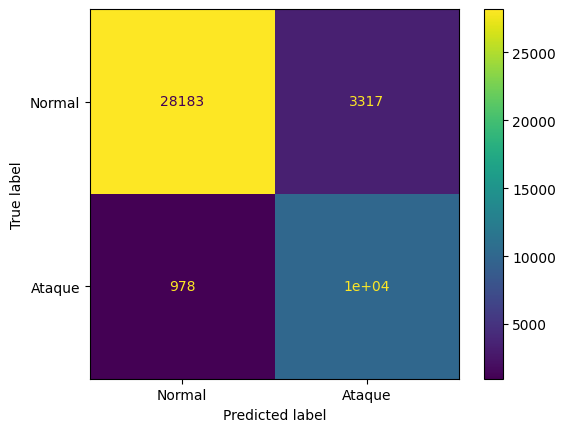

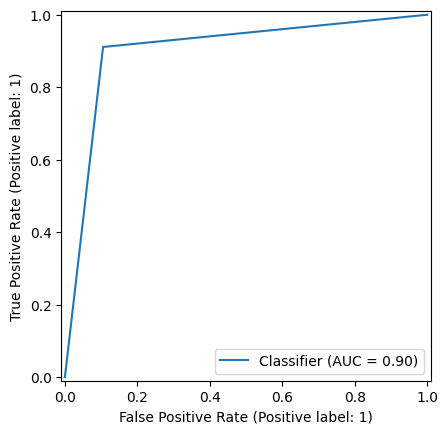

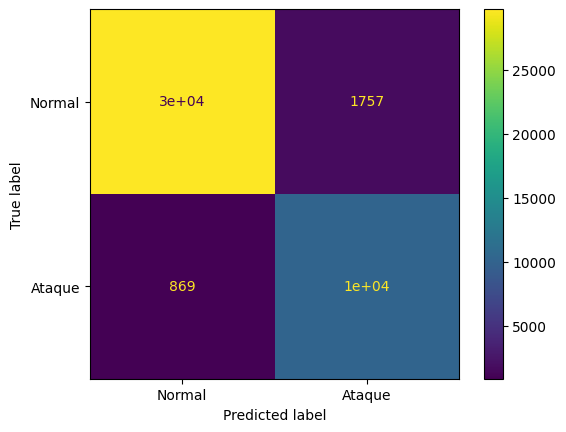

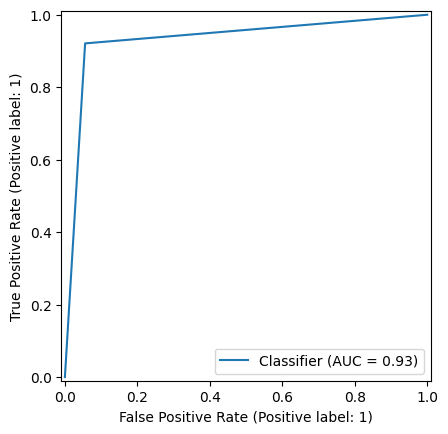

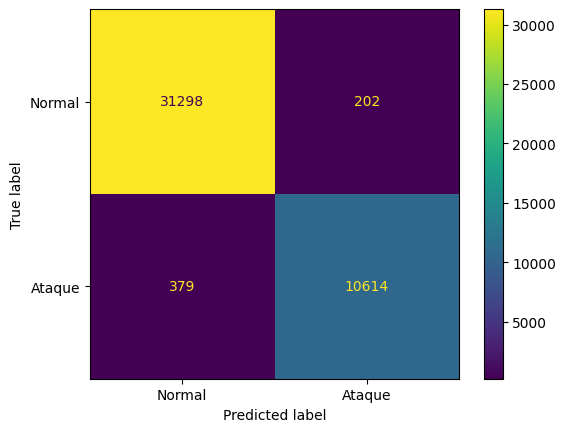

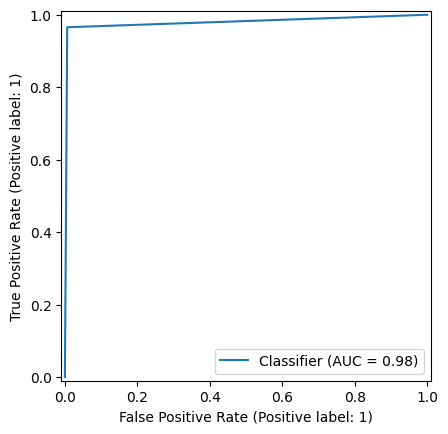

In [83]:
predicao_dst = predicao_modelos(modelo_dst)
predicao_rf = predicao_modelos(modelo_rf)
predicao_xgb = predicao_modelos(modelo_xgb)

Plotagem dos 3 ROCs em apenas um gráfico

In [84]:
# disp1 = RocCurveDisplay.from_predictions(y_test, predicao_dst, name="Decision Tree")
# disp2 = RocCurveDisplay.from_predictions(y_test, predicao_rf, name="Random Forest")
# disp3 = RocCurveDisplay.from_predictions(y_test, predicao_xgb, name="XGBoost")

# # Plotando todos no mesmo gráfico
# plt.figure(figsize=(10, 7))
# disp1.plot(ax=plt.gca())
# disp2.plot(ax=plt.gca())
# disp3.plot(ax=plt.gca())

# plt.title("Curvas ROC - Comparação de Modelos")
# plt.xlabel("Taxa de Falsos Positivos")
# plt.ylabel("Taxa de Verdadeiros Positivos")
# plt.grid(True)
# plt.legend(loc="lower right")
# plt.show()

### Teste dos hiperparâmetros

In [88]:
from sklearn.model_selection import GridSearchCV

params = {
    "learning_rate": [0.1, 0.2, 0.3],
    "max_depth": [0, 2, 4, 6, 10],
    "colsample_bytree": [0.1, 0.5, 1],
    "n_estimators": [10, 25, 50]
}

modelo_xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=params, cv=4, scoring='roc_auc', verbose=1)

grid_search.fit(x, y)

print('Melhores parâmetros encontrados:', grid_search.best_params_)
print('Melhor acurácia encontrada: ', grid_search.best_score_)

modelo_xgb.fit(X_train, y_train)

previsao_pura = modelo_xgb.predict(X_test)

print(classification_report(y_test, previsao_pura))

Fitting 4 folds for each of 135 candidates, totalling 540 fits


c:\Users\arman\Documents\Faculdade\TCC\tcc-implementacao\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 0, 'n_estimators': 25}
Melhor acurácia encontrada:  0.9910994877455143
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31500
           1       0.98      0.97      0.97     10993

    accuracy                           0.99     42493
   macro avg       0.98      0.98      0.98     42493
weighted avg       0.99      0.99      0.99     42493



In [93]:
modelo_xgb2 = XGBClassifier(objective='binary:logistic', colsample_bytree=1, learning_rate=0.2, max_depth=0, n_estimators=25)

modelo_xgb2.fit(X_train, y_train)
previsao_melhorada = modelo_xgb2.predict(X_test)

print(classification_report(y_test, previsao_melhorada))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31500
           1       0.98      0.97      0.97     10993

    accuracy                           0.99     42493
   macro avg       0.98      0.98      0.98     42493
weighted avg       0.99      0.99      0.99     42493



In [96]:

params = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
modelo_dst = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=modelo_dst, param_grid=params, cv=4, scoring='roc_auc', verbose=1)

grid_search.fit(x, y)

print('Melhores parâmetros encontrados:', grid_search.best_params_)
print('Melhor acurácia encontrada: ', grid_search.best_score_)

modelo_dst.fit(X_train, y_train)
previsao_pura = modelo_dst.predict(X_test)
print(classification_report(y_test, previsao_pura))



Fitting 4 folds for each of 18 candidates, totalling 72 fits
Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Melhor acurácia encontrada:  0.958636174789155
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     31500
           1       0.95      0.97      0.96     10993

    accuracy                           0.98     42493
   macro avg       0.97      0.98      0.97     42493
weighted avg       0.98      0.98      0.98     42493



In [98]:
modelo_dst2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)

modelo_dst2.fit(X_train, y_train)
previsao_melhorada = modelo_dst2.predict(X_test)

print(classification_report(y_test, previsao_melhorada))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     31500
           1       0.98      0.94      0.96     10993

    accuracy                           0.98     42493
   macro avg       0.98      0.97      0.97     42493
weighted avg       0.98      0.98      0.98     42493



In [ ]:
params = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}


modelo_rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=modelo_rf, param_grid=params, cv=4, scoring='roc_auc', verbose=1)

grid_search.fit(x, y)

print('Melhores parâmetros encontrados:', grid_search.best_params_)
print('Melhor acurácia encontrada: ', grid_search.best_score_)

modelo_dst.fit(X_train, y_train)
previsao_pura = modelo_dst.predict(X_test)
print(classification_report(y_test, previsao_pura))

Fitting 4 folds for each of 240 candidates, totalling 960 fits


### Testes com a base de dados desequilibrada

Teste usando a base de dados desequilibrada para entender a diferença que isso implica quando for usar o `predict` no modelo treinado com a base equilibrada


In [85]:
# # Garantindo que a coluna 'attack_type' é tratada como objeto
# df_test['attack_type'] = df_test['attack_type'].astype('object')

# # Convertendo todos os valores diferentes de 'benign' para 1
# df_test.loc[df_test['attack_type'] != 'benign', 'attack_type'] = 1
# df_test.loc[df_test['attack_type'] == 'benign', 'attack_type'] = 0

# df_test['attack_type'] = df_test['attack_type'].astype('int')

# y = df_test['attack_type']
# x = df_test.drop('attack_type', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.3, stratify=y, random_state=20)

In [86]:
# predicao = modelo_xgb.predict(X_test)

# print(classification_report(y_test, predicao))

# ConfusionMatrixDisplay.from_predictions(y_test, predicao, display_labels=['Normal', 'Ataque'])

# print(confusion_matrix(y_test, predicao))

# RocCurveDisplay.from_predictions(y_test, predicao)

# modelo_dst = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight='balanced')
# modelo_dst.fit(X_train, y_train)

# modelo_rf = RandomForestClassifier(n_estimators=10, max_depth=3, class_weight='balanced', random_state=42)
# modelo_rf.fit(X_train, y_train)

# modelo_xgb = XGBClassifier(eval_metric='logloss')
# modelo_xgb.fit(X_train, y_train)